# Image classification

影像分類（image classification）是將影像賦予標籤或類別的過程。不同於文本或音頻分類，輸入是影像上的像素值。影像分類有很多應用，例如在自然災害後檢測損壞情況，監測農作物的健康狀況或幫助篩檢醫學影像中的病徵。

以下內容會說明：
1. 在 Food-101 資料集上微調 ViT 模型，以便將影像中的食物進行分類。
2. 使用微調後的模型進行推論。

>以下所演示的任務得以使用的模型架構是：[BEiT](https://huggingface.co/docs/transformers/model_doc/beit), [BiT](https://huggingface.co/docs/transformers/model_doc/bit), [ConvNeXT](https://huggingface.co/docs/transformers/model_doc/convnext), [ConvNeXTV2](https://huggingface.co/docs/transformers/model_doc/convnextv2), [CvT](https://huggingface.co/docs/transformers/model_doc/cvt), [Data2VecVision](https://huggingface.co/docs/transformers/model_doc/data2vec-vision), [DeiT](https://huggingface.co/docs/transformers/model_doc/deit), [DiNAT](https://huggingface.co/docs/transformers/model_doc/dinat), [EfficientFormer](https://huggingface.co/docs/transformers/model_doc/efficientformer), [EfficientNet](https://huggingface.co/docs/transformers/model_doc/efficientnet), [ImageGPT](https://huggingface.co/docs/transformers/model_doc/imagegpt), [LeViT](https://huggingface.co/docs/transformers/model_doc/levit), [MobileNetV1](https://huggingface.co/docs/transformers/model_doc/mobilenet_v1), [MobileNetV2](https://huggingface.co/docs/transformers/model_doc/mobilenet_v2), [MobileViT](https://huggingface.co/docs/transformers/model_doc/mobilevit), [NAT](https://huggingface.co/docs/transformers/model_doc/nat), [Perceiver](https://huggingface.co/docs/transformers/model_doc/perceiver), [PoolFormer](https://huggingface.co/docs/transformers/model_doc/poolformer), [RegNet](https://huggingface.co/docs/transformers/model_doc/regnet), [ResNet](https://huggingface.co/docs/transformers/model_doc/resnet), [SegFormer](https://huggingface.co/docs/transformers/model_doc/segformer), [Swin Transformer](https://huggingface.co/docs/transformers/model_doc/swin), [Swin Transformer V2](https://huggingface.co/docs/transformers/model_doc/swinv2), [VAN](https://huggingface.co/docs/transformers/model_doc/van), [ViT](https://huggingface.co/docs/transformers/model_doc/vit), [ViT Hybrid](https://huggingface.co/docs/transformers/model_doc/vit_hybrid), [ViTMSN](https://huggingface.co/docs/transformers/model_doc/vit_msn)

在開始之前，確認已安裝所有必要的套件：

Before you begin, make sure you have all the necessary libraries installed:

In [ ]:
!pip install -q transformers==4.28.1 datasets evaluate

## Load Food-101 dataset


首先，從 Hugging Face 資料庫中載入 Food-101 資料集的部分資料。這能預先進行多項實驗，確保在完整資料集上進行更多的訓練前，所有步驟都能夠正常運作。

In [2]:
from datasets import load_dataset

food = load_dataset("food101", split="train[:5000]")

Found cached dataset food101 (/home/jovyan/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295)


In [3]:
food

Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})

In [4]:
item = next(iter(food))

6


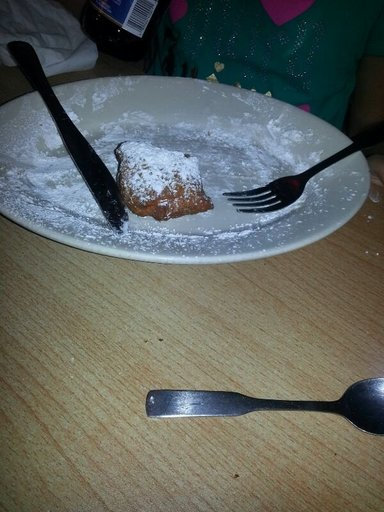

In [5]:
print(item['label'])
item['image']

使用 train_test_split 方法將資料集的訓練部分再進一步切分成訓練集和測試集：

In [6]:
food = food.train_test_split(test_size=0.2)

In [7]:
food

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

查看其中一個樣本：

In [8]:
food["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x512>,
 'label': 6}

資料集中每個範例都有兩個欄位：
* image: 包含食物的 PIL(pillow 格式) 影像
* label: 食物的標籤類別

為了讓模型更容易從標籤 id 中讀取名稱，創建一個將標籤名稱對應到整數以及反對應的字典：

In [9]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [10]:
labels[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

現在，按照標籤 id 轉換成名稱：

In [11]:
id2label[str(79)]

'prime_rib'

---

## Preprocess


接下來的步驟是載入 ViT 模型使用的影像處理器，將影像處理成張量：

In [12]:
from transformers import AutoImageProcessor
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [13]:
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

---
將影像進行轉換，使模型更具一般性以應付過擬合的情況。這裡會使用的 torchvision 中 transforms 的模組，但也能替換成其他適用的影像處理套件。

隨機裁減影像的一部份，將其調整影像大小，並使用影像的平均值和標準差進行標準化：

In [14]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

接下來創建一個預處理函數，轉換並回傳影像的像素值作為模型的輸入：

In [15]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

要在整個資料集上應用預處理函數，可以使用 Hugging Face 資料集的 [with_transform](https://huggingface.co/docs/datasets/v2.11.0/en/package_reference/main_classes#datasets.Dataset.with_transform) 方法。當載入資料集的一個元素時，轉換會即時套用：

In [16]:
food = food.with_transform(transforms)

In [17]:
food

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

In [45]:
import matplotlib.pyplot as plt
import torch

In [33]:
item = next(iter(food['train']))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6
torch.Size([3, 224, 224])


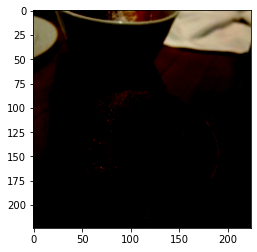

In [56]:
print(item['label'])
print(item['pixel_values'].size())
plt.imshow(torch.permute(item['pixel_values'], (1, 2, 0)))

現在使用 [DefaultDataCollator](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/data_collator#transformers.DefaultDataCollator) 創建一個批次樣本。與 Hugging face 裡 Transformers 的其他資料收集器不同，DefaultDataCollator 不會套用額外的預處理，例如填充（padding）。

In [18]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

## Evaluate

在訓練過程中加入評估指標通常有助於評估模型的表現。可以使用 Hugging Face 的 [Evaluate](https://huggingface.co/docs/evaluate/index) 函式庫快速載入評估方法。在此任務上載入 [accuracy](https://huggingface.co/spaces/evaluate-metric/accuracy) 指標（請參閱 Hugging Face 的 Evaluate [快速導覽](https://huggingface.co/docs/evaluate/a_quick_tour)，以了解如何載入和計算指標的詳細資訊）：

In [19]:
import evaluate

accuracy = evaluate.load("accuracy")

然後創建一個函數，將預測及標籤使用 [compute](https://huggingface.co/docs/evaluate/v0.4.0/en/package_reference/main_classes#evaluate.EvaluationModule.compute) 以計算準確度：

In [20]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

定義完 compute_metrics 函數，在訓練設定時會再次使用到它。

>如果不熟悉使用 [Trainer]((https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.Trainer)) 微調模型，請參考此[基本教程](https://huggingface.co/docs/transformers/training#train-with-pytorch-trainer)！

現在已準備好開始訓練模型了！使用 [AutoModelForImageClassification](https://huggingface.co/docs/transformers/v4.28.1/en/model_doc/auto#transformers.AutoModelForImageClassification) 載入 ViT。指定標籤的數量以及標籤的對應方式：

In [21]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


接著的階段，只剩以下三個步驟：

1. 在 [TrainingArguments](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.TrainingArguments) 中定義訓練的超參數。請務必留意資料集中未使用的資訊，設定 remove_unused_columns=False 可以防止被刪除未使用到的資訊！例如 image，這會導致無法獲得 pixel_values。另一個必需設定的參數是 output_dir，指定模型儲存的位置。通過設定 push_to_hub=True 將模型上傳至 Hub（需要登入 Hugging Face 才能上傳模型）。在每個 epoch 結束時，[Trainer](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.Trainer) 將評估準確性並儲存訓練模型。
2. 將訓練參數、模型、資料集、預處理器、資料收集器以及計算評估指標函數傳遞給 [Trainer](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.Trainer)。
3. 呼叫 [train](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.Trainer.train) 來微調模型。

In [22]:
training_args = TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy")

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

In [24]:
from transformers.integrations import MLflowCallback
trainer.remove_callback(MLflowCallback)
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 186
  Number of trainable parameters = 85876325


Epoch,Training Loss,Validation Loss,Accuracy
0,2.708800,2.519541,0.858000
1,1.837700,1.764556,0.875000
2,1.580800,1.583854,0.905000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
Saving model checkpoint to my_awesome_food_model/checkpoint-62
Configuration saved in my_awesome_food_model/checkpoint-62/config.json
Model weights saved in my_awesome_food_model/checkpoint-62/pytorch_model.bin
Image processor saved in my_awesome_food_model/checkpoint-62/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
Saving model checkpoint to my_awesome_food_model/checkpoint-124
Configuration saved in my_awesome_food_model/checkpoint-124/config.json
Model weights saved in my_awesome_food_model/checkpoint-124/pytorch_model.bin
Image processor saved in my_awesome_food_model/checkpoint-124/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
Saving model checkpoint to my_awesome_food_model/checkpoint-186
Configuration saved in my_awesome_food_model/checkpoint-186/config.json
Model weights saved in my_awesome_food_model/checkpoi

TrainOutput(global_step=186, training_loss=2.4226781527201333, metrics={'train_runtime': 328.5459, 'train_samples_per_second': 36.525, 'train_steps_per_second': 0.566, 'total_flos': 9.282470404128768e+17, 'train_loss': 2.4226781527201333, 'epoch': 2.99})

## Inference

現在，微調後的模型以存放在指定路徑，並可使用它來進行推論！

載入想要進行推論的影像：

In [57]:
ds = load_dataset("food101", split="validation[:10]")
image = ds["image"][0]

Found cached dataset food101 (/home/jovyan/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295)


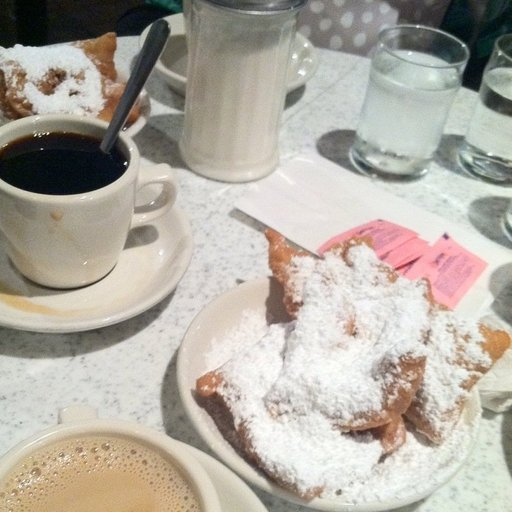

In [58]:
image

使用微調後的模型進行推論最簡單的方法是在 pipline() 中設定。藉由指定的模型建構一個影像分類的 pipeline，然後將影像傳遞給它：

In [69]:
from transformers import pipeline

classifier = pipeline("image-classification", model="my_awesome_food_model/checkpoint-186/")
classifier(image)

loading configuration file my_awesome_food_model/checkpoint-186/config.json
Model config ViTConfig {
  "_name_or_path": "my_awesome_food_model/checkpoint-186/",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "apple_pie",
    "1": "baby_back_ribs",
    "2": "baklava",
    "3": "beef_carpaccio",
    "4": "beef_tartare",
    "5": "beet_salad",
    "6": "beignets",
    "7": "bibimbap",
    "8": "bread_pudding",
    "9": "breakfast_burrito",
    "10": "bruschetta",
    "11": "caesar_salad",
    "12": "cannoli",
    "13": "caprese_salad",
    "14": "carrot_cake",
    "15": "ceviche",
    "16": "cheesecake",
    "17": "cheese_plate",
    "18": "chicken_curry",
    "19": "chicken_quesadilla",
    "20": "chicken_wings",
    "21": "chocolate_cake",
    "22": "chocolate_mousse",
    "23": "churros",
    "24": "clam_chowder",

[{'score': 0.2807473838329315, 'label': 'beignets'},
 {'score': 0.015582279302179813, 'label': 'bruschetta'},
 {'score': 0.015377962961792946, 'label': 'hamburger'},
 {'score': 0.014721986837685108, 'label': 'chicken_wings'},
 {'score': 0.013076224364340305, 'label': 'ramen'}]

載入影像處理器對影像進行預處理，並以 PyTorch 的張量型態回傳作為輸入：

In [62]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("my_awesome_food_model/checkpoint-186/")
inputs = image_processor(image, return_tensors="pt")

loading configuration file my_awesome_food_model/checkpoint-186/preprocessor_config.json
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



將輸入傳遞給模型，並回傳 logits（尚未經過 softmax）：

In [65]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("my_awesome_food_model/checkpoint-186/")
with torch.no_grad():
    logits = model(**inputs).logits

loading configuration file my_awesome_food_model/checkpoint-186/config.json
Model config ViTConfig {
  "_name_or_path": "my_awesome_food_model/checkpoint-186/",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "apple_pie",
    "1": "baby_back_ribs",
    "2": "baklava",
    "3": "beef_carpaccio",
    "4": "beef_tartare",
    "5": "beet_salad",
    "6": "beignets",
    "7": "bibimbap",
    "8": "bread_pudding",
    "9": "breakfast_burrito",
    "10": "bruschetta",
    "11": "caesar_salad",
    "12": "cannoli",
    "13": "caprese_salad",
    "14": "carrot_cake",
    "15": "ceviche",
    "16": "cheesecake",
    "17": "cheese_plate",
    "18": "chicken_curry",
    "19": "chicken_quesadilla",
    "20": "chicken_wings",
    "21": "chocolate_cake",
    "22": "chocolate_mousse",
    "23": "churros",
    "24": "clam_chowder",

In [67]:
predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]

'beignets'

---
## Conclusion - HuggingFace Workflows

![](https://hackmd.io/_uploads/HkEzgZdwh.png)